In [2]:
import numpy as np
import pandas as pd
from typing import Dict, Tuple, Optional, Literal


def get_behavior_group_counts(
    df: pd.DataFrame,
    behavior_type: Literal["vacc", "masks", "testing"]
) -> np.ndarray:
    """
    Get the count of individuals in each behavior group.
    
    Args:
        df: DataFrame containing survey data
        behavior_type: Type of behavior ("vacc", "masks", or "testing")
        
    Returns:
        Array of counts for each behavior group (5 bins)
    """
    # Clean data and prepare
    df_clean = df.dropna(subset=[f'{behavior_type}_self'])
    n_bins = 5
    
    # Get self-reported behavior
    self_behavior = df_clean[f'{behavior_type}_self'].astype(int)
    
    # Count individuals per self-reported group
    group_counts = np.zeros(n_bins)
    for i in range(n_bins):
        group_counts[i] = np.sum(self_behavior == i+1)
    
    return group_counts


def calculate_polarization_with_error(
    behavior_values: np.ndarray, 
    behavior_positions: Optional[np.ndarray] = None,
    n_bootstrap: int = 1000,
    confidence_level: float = 0.95
) -> Dict:
    """
    Calculate polarization (4 * variance) and its error from behavior values.
    
    Parameters:
    -----------
    behavior_values : array-like
        Values representing counts or raw frequencies at each behavior level.
        Will be normalized within the function.
    behavior_positions : array-like, optional
        Positions corresponding to each behavior value.
        If None, positions will be evenly spaced from 0 to 1.
    n_bootstrap : int, default=1000
        Number of bootstrap samples to use for error estimation.
    confidence_level : float, default=0.95
        Confidence level for the error bounds.
    
    Returns:
    --------
    dict
        A dictionary containing:
        - mean: the mean of the distribution
        - variance: the variance of the distribution
        - polarization: 4 * variance
        - polarization_std_error: standard error of polarization
        - polarization_ci: confidence interval for polarization
    """
    # Convert input to numpy array
    values = np.array(behavior_values, dtype=float)
    
    # Normalize values to probabilities
    total = np.sum(values)
    if total <= 0:
        raise ValueError("behavior_values must sum to a positive value")
    prob_values = values / total
    
    # If positions not provided, create evenly spaced positions from 0 to 1
    if behavior_positions is None:
        positions = np.linspace(0, 1, len(values))
    else:
        positions = np.array(behavior_positions)
    
    # Ensure the arrays are the same length
    if len(positions) != len(values):
        raise ValueError("behavior_values and behavior_positions must have the same length")
    
    # Function to calculate polarization from probability values
    def calc_pol(probs):
        mean = np.sum(positions * probs)
        variance = np.sum(probs * (positions - mean)**2)
        return 4 * variance
    
    # Calculate polarization for the original data
    polarization = calc_pol(prob_values)
    
    # Bootstrap to estimate error
    bootstrap_polarizations = []
    for _ in range(n_bootstrap):
        # Generate bootstrap sample (multinomial draw)
        bootstrap_sample = np.random.multinomial(total, prob_values, size=1)[0]
        bootstrap_probs = bootstrap_sample / np.sum(bootstrap_sample)
        bootstrap_polarizations.append(calc_pol(bootstrap_probs))
    
    # Calculate statistics from bootstrap samples
    bootstrap_polarizations = np.array(bootstrap_polarizations)
    polarization_std_error = np.std(bootstrap_polarizations, ddof=1)
    
    # Calculate confidence interval
    alpha = 1 - confidence_level
    lower_percentile = alpha / 2 * 100
    upper_percentile = (1 - alpha / 2) * 100
    polarization_ci = np.percentile(bootstrap_polarizations, [lower_percentile, upper_percentile])
    
    # Calculate mean and variance for original data
    mean = np.sum(positions * prob_values)
    variance = np.sum(prob_values * (positions - mean)**2)
    
    return {
        'mean': mean,
        'variance': variance,
        'polarization': polarization,
        'polarization_std_error': polarization_std_error,
        'polarization_ci': polarization_ci
    }


def analyze_behavior_polarization(df: pd.DataFrame) -> Dict:
    """
    Analyze polarization for all three behavior types in the dataset.
    
    Args:
        df: DataFrame containing survey data
        
    Returns:
        Dictionary with polarization results for masks, testing, and vaccination
    """
    results = {}
    
    for behavior_type in ["masks", "testing", "vacc"]:
        behavior_counts = get_behavior_group_counts(df, behavior_type)
        pol_results = calculate_polarization_with_error(behavior_counts)
        results[behavior_type] = pol_results
    
    return results


def print_polarization_results(results: Dict) -> None:
    """
    Print the polarization results in a formatted table.
    
    Args:
        results: Dictionary with polarization results
    """
    print("Polarization Analysis Results:")
    print("-" * 80)
    print(f"{'Behavior':<12} {'Polarization':<12} {'Std Error':<12} {'95% CI':<20}")
    print("-" * 80)
    
    behavior_labels = {
        "masks": "Masks",
        "testing": "Testing", 
        "vacc": "Vaccination"
    }
    
    for behavior_type, label in behavior_labels.items():
        pol = results[behavior_type]['polarization']
        err = results[behavior_type]['polarization_std_error']
        ci = results[behavior_type]['polarization_ci']
        ci_str = f"[{ci[0]:.4f}, {ci[1]:.4f}]"
        
        print(f"{label:<12} {pol:<12.4f} {err:<12.4f} {ci_str:<20}")

In [3]:
import jax
import jax.numpy as jnp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import Dict, Tuple, List, Literal, Optional

# Assuming access to these functions from the project code
from src.utils.Contact_Matrix import create_contact_matrix, matrix_scaling


def generate_matrices_and_vectors(
    df: pd.DataFrame,
    apply_sinkhorn: bool = True,
    symmetrize: bool = True,
    max_iters: int = 1000,
    threshold: float = 1e-6
) -> Tuple[Dict[str, jnp.ndarray], Dict[str, jnp.ndarray]]:
    """
    Generate contact matrices and behavior vectors for mask, test, and vaccine.
    
    Args:
        df: DataFrame containing survey data
        apply_sinkhorn: Whether to apply Sinkhorn normalization
        symmetrize: Whether to symmetrize the matrix before normalization
        max_iters: Maximum iterations for Sinkhorn normalization
        threshold: Convergence threshold for Sinkhorn normalization
        
    Returns:
        Tuple of:
        - Dictionary of contact matrices for each behavior type
        - Dictionary of behavior vectors for each behavior type
    """
    behavior_types = ["masks", "testing", "vacc"]
    matrices = {}
    behavior_vectors = {}
    n_bins = 5
    
    for behavior_type in behavior_types:
        # Clean data and prepare
        df_clean = df.dropna(subset=[f'{behavior_type}_self'])
        
        # Get self-reported behavior and calculate behavior vector
        self_behavior = df_clean[f'{behavior_type}_self'].astype(int)
        behavior_vector = np.zeros(n_bins)
        for i in range(n_bins):
            behavior_vector[i] = np.sum(self_behavior == i+1)
        behavior_vector = behavior_vector / np.sum(behavior_vector)  # Normalize
        behavior_vectors[behavior_type] = jnp.array(behavior_vector)
        
        # Initialize contact matrix
        contact_matrix = np.zeros((n_bins, n_bins))
        
        # Fill contact matrix based on behavior type
        if behavior_type == "vacc":
            cols = [f'{behavior_type}_others0{i+1}' for i in range(n_bins)]
        else:
            cols = [
                f'{behavior_type}_others_never', 
                f'{behavior_type}_others_sometimes',
                f'{behavior_type}_others_half',
                f'{behavior_type}_others_often',
                f'{behavior_type}_others_always'
            ]
        
        # Aggregate responses into contact matrix
        for i, row in df_clean.iterrows():
            self_idx = int(row[f'{behavior_type}_self']) - 1
            for j, col in enumerate(cols):
                if pd.notna(row[col]):
                    contact_matrix[self_idx, j] += row[col]
        
        # Normalize by group counts to get average connections per individual
        raw_normalized = np.zeros_like(contact_matrix)
        for i in range(n_bins):
            group_count = np.sum(self_behavior == i+1)
            if group_count > 0:
                raw_normalized[i, :] = contact_matrix[i, :] / group_count
        
        # Symmetrize if requested
        if symmetrize:
            raw_normalized = 0.5 * (raw_normalized + raw_normalized.T)
        
        # Convert to JAX array
        raw_normalized_jax = jnp.array(raw_normalized)
        
        # Apply Sinkhorn normalization if requested
        if apply_sinkhorn:
            sinkhorn_normalized, _, _ = matrix_scaling(
                raw_normalized_jax, 
                max_iters=max_iters, 
                threshold=threshold
            )
            # Apply scaling after normalization
            matrices[behavior_type] = sinkhorn_normalized * (n_bins**2)
        else:
            matrices[behavior_type] = raw_normalized_jax * (n_bins**2)
    
    return matrices, behavior_vectors


def calculate_optimal_homophily(
    matrices: Dict[str, jnp.ndarray],
    behavior_vectors: Dict[str, jnp.ndarray],
    h_range: Tuple[float, float] = (-10, 10),
    n_samples: int = 1000
) -> Tuple[Dict[str, float], Dict[str, Dict[float, float]]]:
    """
    Calculate the optimal homophily parameter and matrix distances for each behavior type.
    
    Args:
        matrices: Dictionary of empirical contact matrices
        behavior_vectors: Dictionary of behavior vectors
        h_range: Range limits for homophily values
        n_samples: Number of homophily values to sample
        
    Returns:
        Tuple of:
        - Dictionary of optimal homophily values for each behavior type
        - Dictionary of dictionaries containing distance metrics for each tested homophily value
    """
    behavior_types = ["masks", "testing", "vacc"]
    h_values = jnp.linspace(h_range[0], h_range[1], n_samples)
    optimal_h = {}
    all_distances = {}
    
    # Function to calculate distance between matrices
    def matrix_distance(m1, m2):
        # Frobenius norm (L2 distance)
        return jnp.sqrt(jnp.sum((m1 - m2) ** 2))
    
    for behavior_type in behavior_types:
        empirical_matrix = matrices[behavior_type]
        populations = behavior_vectors[behavior_type]
        n_groups = len(populations)
        
        # Calculate distance for each homophily value
        distances = {}
        
        for h in h_values:
            synthetic_matrix = create_contact_matrix(n_groups, h, populations)
            dist = matrix_distance(synthetic_matrix, empirical_matrix)
            distances[float(h)] = float(dist)
        
        # Find optimal homophily
        optimal_h[behavior_type] = min(distances, key=distances.get)
        all_distances[behavior_type] = distances
    
    return optimal_h, all_distances


def bootstrap_homophily_estimation(
    df: pd.DataFrame,
    behavior_type: Literal["vacc", "masks", "testing"],
    n_bootstrap: int = 1000,
    h_range: Tuple[float, float] = (-10, 10),
    n_h_samples: int = 200,
    confidence_level: float = 0.95,
    apply_sinkhorn: bool = True,
    symmetrize: bool = True
) -> Dict:
    """
    Estimate homophily parameter with bootstrap confidence intervals.
    
    Args:
        df: DataFrame containing survey data
        behavior_type: Type of behavior
        n_bootstrap: Number of bootstrap samples
        h_range: Range of homophily values to test
        n_h_samples: Number of homophily values to sample within range
        confidence_level: Confidence level for intervals
        apply_sinkhorn: Whether to apply Sinkhorn normalization
        symmetrize: Whether to symmetrize matrices
        
    Returns:
        Dictionary with results including optimal h, standard error, and confidence intervals
    """
    # Clean data
    df_clean = df.dropna(subset=[f'{behavior_type}_self'])
    n_bins = 5
    
    # Get relevant columns based on behavior type
    if behavior_type == "vacc":
        cols = [f'{behavior_type}_self'] + [f'{behavior_type}_others0{i+1}' for i in range(n_bins)]
    else:
        cols = [
            f'{behavior_type}_self', 
            f'{behavior_type}_others_never', 
            f'{behavior_type}_others_sometimes',
            f'{behavior_type}_others_half',
            f'{behavior_type}_others_often',
            f'{behavior_type}_others_always'
        ]
    
    # Get matrices and vectors for original data
    matrices, behavior_vectors = generate_matrices_and_vectors(
        df, 
        apply_sinkhorn=apply_sinkhorn, 
        symmetrize=symmetrize
    )
    
    original_matrix = matrices[behavior_type]
    populations = behavior_vectors[behavior_type]
    
    # Calculate optimal homophily on original data
    h_values = jnp.linspace(h_range[0], h_range[1], n_h_samples)
    distances = {}
    
    # Define matrix distance function
    def matrix_distance(m1, m2):
        return jnp.sqrt(jnp.sum((m1 - m2) ** 2))
    
    # Calculate distances for each h value using original data
    for h in h_values:
        synthetic_matrix = create_contact_matrix(n_bins, h, populations)
        dist = float(matrix_distance(synthetic_matrix, original_matrix))
        distances[float(h)] = dist
    
    # Find optimal homophily
    original_optimal_h = min(distances, key=distances.get)
    
    # Prepare for bootstrap
    bootstrap_h_values = []
    
    # Perform bootstrap resampling
    for _ in range(n_bootstrap):
        # Sample with replacement
        bootstrap_indices = np.random.choice(len(df_clean), size=len(df_clean), replace=True)
        bootstrap_sample = df_clean.iloc[bootstrap_indices].copy()
        
        # Create empirical matrix from bootstrap sample
        bs_matrices, bs_vectors = generate_matrices_and_vectors(
            bootstrap_sample,
            apply_sinkhorn=apply_sinkhorn,
            symmetrize=symmetrize
        )
        
        bs_matrix = bs_matrices[behavior_type]
        bs_populations = bs_vectors[behavior_type]
        
        # Calculate distances for bootstrap sample
        bs_distances = {}
        for h in h_values:
            synthetic_matrix = create_contact_matrix(n_bins, h, bs_populations)
            dist = float(matrix_distance(synthetic_matrix, bs_matrix))
            bs_distances[float(h)] = dist
        
        # Find optimal homophily for this bootstrap sample
        bs_optimal_h = min(bs_distances, key=bs_distances.get)
        bootstrap_h_values.append(bs_optimal_h)
    
    # Calculate bootstrap statistics
    bootstrap_h_values = np.array(bootstrap_h_values)
    h_mean = np.mean(bootstrap_h_values)
    h_std_error = np.std(bootstrap_h_values, ddof=1)
    
    # Calculate confidence interval
    alpha = 1 - confidence_level
    lower_percentile = alpha / 2 * 100
    upper_percentile = (1 - alpha / 2) * 100
    h_ci = np.percentile(bootstrap_h_values, [lower_percentile, upper_percentile])
    
    return {
        'behavior_type': behavior_type,
        'optimal_h': original_optimal_h,
        'bootstrap_mean_h': h_mean,
        'h_std_error': h_std_error,
        'h_ci': h_ci,
        'bootstrap_samples': bootstrap_h_values,
        'distances': distances
    }


def analyze_all_behaviors_homophily(
    df: pd.DataFrame,
    n_bootstrap: int = 1000,
    h_range: Tuple[float, float] = (-10, 10),
    n_h_samples: int = 200,
    confidence_level: float = 0.95
) -> Dict[str, Dict]:
    """
    Analyze all behavior types' homophily with bootstrap confidence intervals.
    
    Args:
        df: DataFrame containing survey data
        n_bootstrap: Number of bootstrap samples
        h_range: Range of homophily values to test
        n_h_samples: Number of homophily values to sample
        confidence_level: Confidence level for intervals
        
    Returns:
        Dictionary mapping behavior types to their analysis results
    """
    behavior_types = ["masks", "testing", "vacc"]
    results = {}
    
    for behavior_type in behavior_types:
        results[behavior_type] = bootstrap_homophily_estimation(
            df,
            behavior_type,
            n_bootstrap=n_bootstrap,
            h_range=h_range,
            n_h_samples=n_h_samples,
            confidence_level=confidence_level
        )
    
    return results


def print_homophily_results(results: Dict[str, Dict]) -> None:
    """
    Print the homophily results in a formatted table.
    
    Args:
        results: Dictionary with homophily results for each behavior type
    """
    print("Homophily Parameter Estimates with Bootstrap Error Analysis:")
    print("-" * 80)
    print(f"{'Behavior':<12} {'Optimal h':<12} {'Std Error':<12} {'95% CI':<20}")
    print("-" * 80)
    
    behavior_labels = {
        "masks": "Masks",
        "testing": "Testing", 
        "vacc": "Vaccination"
    }
    
    for behavior_type, label in behavior_labels.items():
        result = results[behavior_type]
        optimal_h = result['optimal_h']
        h_std_error = result['h_std_error']
        h_ci = result['h_ci']
        ci_str = f"[{h_ci[0]:.4f}, {h_ci[1]:.4f}]"
        
        print(f"{label:<12} {optimal_h:<12.4f} {h_std_error:<12.4f} {ci_str:<20}")

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import Dict, Tuple, List, Optional, Literal
import jax.numpy as jnp


def plot_behavior_histogram(ax, behavior_vector, title):
    """
    Plot histogram of self-reported behavior.
    
    Args:
        ax: Matplotlib axis
        behavior_vector: Vector of behavior counts/proportions
        title: Plot title
    """
    ax.bar(range(1, len(behavior_vector)+1), behavior_vector)
    ax.set_title(title)
    ax.set_xlabel("Behavior Level")
    ax.set_ylabel("Proportion")
    ax.set_xticks(range(1, len(behavior_vector)+1))
    ax.grid(axis='y', linestyle='--', alpha=0.7)


def plot_contact_matrix(ax, matrix, title):
    """
    Plot contact matrix as a heatmap.
    
    Args:
        ax: Matplotlib axis
        matrix: Contact matrix
        title: Plot title
    """
    im = ax.imshow(matrix, cmap='viridis')
    ax.set_title(title)
    ax.set_xlabel("Others' Behavior")
    ax.set_ylabel("Self Behavior")
    ax.set_xticks(range(len(matrix)))
    ax.set_yticks(range(len(matrix)))
    ax.set_xticklabels(range(1, len(matrix)+1))
    ax.set_yticklabels(range(1, len(matrix)+1))
    plt.colorbar(im, ax=ax)


def plot_distance_curve_with_ci(ax, h_vals, distances, optimal_h, ci_bounds, title):
    """
    Plot distance curve with confidence interval from bootstrap.
    
    Args:
        ax: Matplotlib axis
        h_vals: Array of homophily values
        distances: Dictionary mapping h values to distances
        optimal_h: Optimal homophily value
        ci_bounds: Confidence interval bounds [lower, upper]
        title: Plot title
    """
    # Sort h values and get corresponding distances
    h_vals_sorted = sorted(h_vals)
    d_vals = [distances[h] for h in h_vals_sorted]
    
    # Plot distance curve
    ax.plot(h_vals_sorted, d_vals, '-', linewidth=2)
    
    # Plot optimal h
    ax.axvline(x=optimal_h, color='r', linestyle='-', 
               label=f'Optimal h = {optimal_h:.2f}')
    
    # Add confidence interval range as shaded area
    ax.axvspan(
        ci_bounds[0], 
        ci_bounds[1], 
        alpha=0.2, 
        color='blue',
        label=f'95% CI: [{ci_bounds[0]:.2f}, {ci_bounds[1]:.2f}]'
    )
    
    # Add vertical lines for CI bounds
    ax.axvline(x=ci_bounds[0], color='blue', linestyle='--', alpha=0.5)
    ax.axvline(x=ci_bounds[1], color='blue', linestyle='--', alpha=0.5)
    
    ax.set_xlabel("Homophily Parameter (h)")
    ax.set_ylabel("Matrix Distance")
    ax.set_title(title)
    ax.legend()
    ax.grid(True)


def generate_comparison_figure(
    matrices: Dict[str, jnp.ndarray],
    behavior_vectors: Dict[str, jnp.ndarray],
    homophily_results: Dict[str, Dict],
    figsize: Tuple[int, int] = (15, 12)
) -> plt.Figure:
    """
    Generate a 3x3 comparison figure for mask, test, and vaccine data,
    with histograms, contact matrices, and distance curves with bootstrap CIs.
    
    Args:
        matrices: Dictionary of contact matrices
        behavior_vectors: Dictionary of behavior vectors
        homophily_results: Dictionary of homophily analysis results
        figsize: Figure size
        
    Returns:
        Matplotlib Figure object
    """
    # Define behavior types and labels
    behavior_types = ["masks", "testing", "vacc"]
    behavior_labels = ["Masks", "Testing", "Vaccination"]
    
    # Create figure
    fig, axes = plt.subplots(3, 3, figsize=figsize)
    
    # Plot data for each behavior type
    for col, (behavior_type, label) in enumerate(zip(behavior_types, behavior_labels)):
        # Top row: Histogram of self-reported behavior
        ax_hist = axes[0, col]
        behavior_vector = behavior_vectors[behavior_type]
        plot_behavior_histogram(ax_hist, behavior_vector, f"{label} Self-Reported Behavior")
        
        # Middle row: Contact matrix
        ax_matrix = axes[1, col]
        plot_contact_matrix(ax_matrix, matrices[behavior_type], f"{label} Contact Matrix")
        
        # Bottom row: Distance curve with bootstrap CI
        ax_dist = axes[2, col]
        result = homophily_results[behavior_type]
        
        # Get h values and sort them
        h_vals = list(result['distances'].keys())
        optimal_h = result['optimal_h']
        ci_bounds = result['h_ci']
        
        plot_distance_curve_with_ci(
            ax_dist, 
            h_vals, 
            result['distances'], 
            optimal_h, 
            ci_bounds, 
            f"{label} Matrix Distance"
        )
    
    plt.tight_layout()
    return fig


def plot_polarization_homophily_comparison(
    polarization_results: Dict[str, Dict],
    homophily_results: Dict[str, Dict],
    figsize: Tuple[int, int] = (10, 6)
) -> plt.Figure:
    """
    Plot a comparison of polarization and homophily values with confidence intervals.
    
    Args:
        polarization_results: Dictionary with polarization results
        homophily_results: Dictionary with homophily results
        figsize: Figure size
        
    Returns:
        Matplotlib Figure object
    """
    fig, ax = plt.subplots(figsize=figsize)
    
    behavior_types = ["masks", "testing", "vacc"]
    behavior_labels = ["Masks", "Testing", "Vaccination"]
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
    
    # Extract values and error bars
    x_vals = []  # Polarization values
    y_vals = []  # Homophily values
    x_errors = []  # Polarization CI as error bar widths
    y_errors = []  # Homophily CI as error bar heights
    
    for behavior_type in behavior_types:
        pol_result = polarization_results[behavior_type]
        hom_result = homophily_results[behavior_type]
        
        # Polarization
        pol_val = pol_result['polarization']
        pol_ci = pol_result['polarization_ci']
        pol_error = [pol_val - pol_ci[0], pol_ci[1] - pol_val]
        
        # Homophily
        hom_val = hom_result['optimal_h']
        hom_ci = hom_result['h_ci']
        hom_error = [hom_val - hom_ci[0], hom_ci[1] - hom_val]
        
        x_vals.append(pol_val)
        y_vals.append(hom_val)
        x_errors.append(pol_error)
        y_errors.append(hom_error)
    
    # Transpose to get [[lower_errors], [upper_errors]] format for pyplot
    x_errors = np.array(x_errors).T
    y_errors = np.array(y_errors).T
    
    # Plot with error bars
    for i, (x, y, label, color) in enumerate(zip(x_vals, y_vals, behavior_labels, colors)):
        ax.errorbar(
            x, y, 
            xerr=[[x_errors[0, i]], [x_errors[1, i]]], 
            yerr=[[y_errors[0, i]], [y_errors[1, i]]], 
            fmt='o', 
            label=label,
            color=color,
            markersize=8,
            capsize=5,
            elinewidth=1.5
        )
    
    ax.set_xlabel('Polarization (4 * Variance)')
    ax.set_ylabel('Homophily Parameter (h)')
    ax.set_title('Comparison of Polarization and Homophily Across Behaviors')
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.7)
    
    return fig

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


Loading data from data_homophily.csv...

Analyzing behavior polarization...
Polarization Analysis Results:
--------------------------------------------------------------------------------
Behavior     Polarization Std Error    95% CI              
--------------------------------------------------------------------------------
Masks        0.2898       0.0125       [0.2634, 0.3145]    
Testing      0.4780       0.0105       [0.4582, 0.4989]    
Vaccination  0.5637       0.0136       [0.5359, 0.5898]    

Generating contact matrices and behavior vectors...

Analyzing homophily with bootstrap confidence intervals...
Homophily Parameter Estimates with Bootstrap Error Analysis:
--------------------------------------------------------------------------------
Behavior     Optimal h    Std Error    95% CI              
--------------------------------------------------------------------------------
Masks        2.4623       0.1542       [2.1608, 2.7638]    
Testing      2.3618       0.1062   

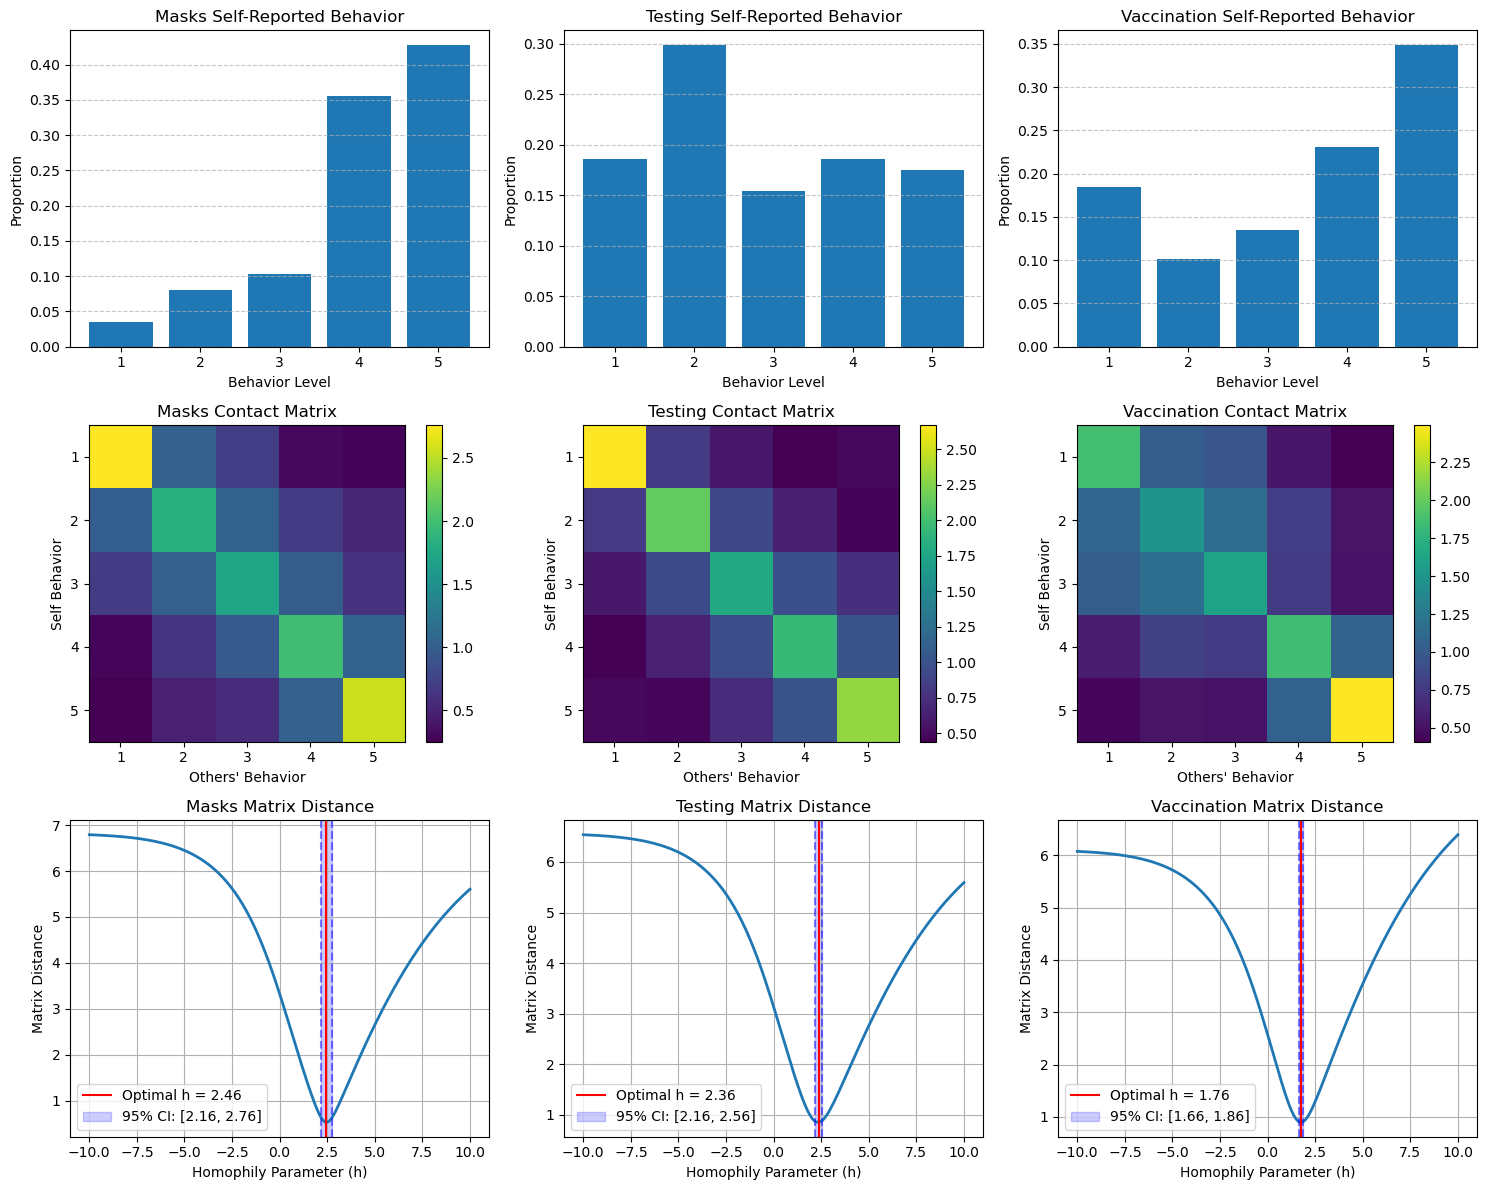

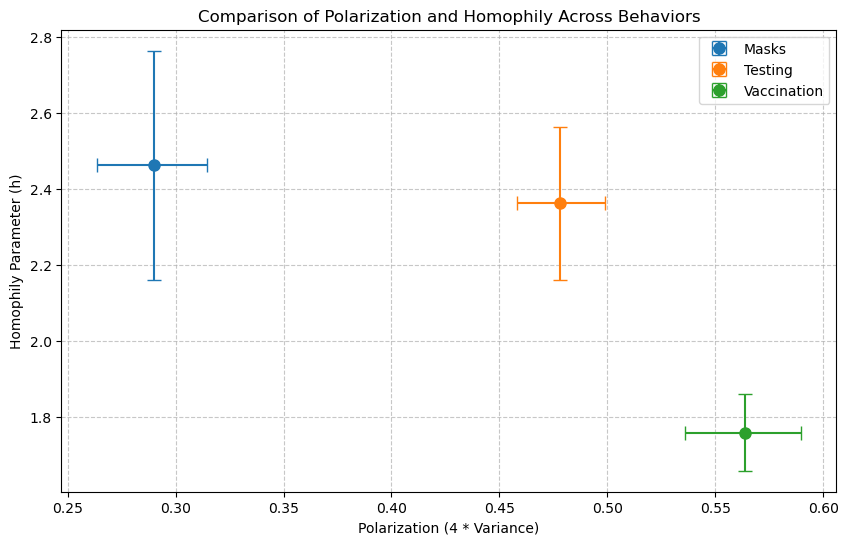

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import Dict, Tuple, Optional
import os


def run_full_analysis(
    csv_path: str,
    output_dir: str = '.',
    n_bootstrap: int = 1000,
    h_range: Tuple[float, float] = (-10, 10),
    n_h_samples: int = 200,
    confidence_level: float = 0.95,
    save_figures: bool = True
) -> Dict:
    """
    Run complete analysis on survey data, including:
    - Polarization analysis with bootstrapped error estimation
    - Homophily parameter estimation with bootstrapped confidence intervals
    - Visualization of results
    
    Args:
        csv_path: Path to the CSV file with survey data
        output_dir: Directory to save output figures
        n_bootstrap: Number of bootstrap samples for error estimation
        h_range: Range of homophily values to test
        n_h_samples: Number of h values to sample
        confidence_level: Confidence level for intervals
        save_figures: Whether to save figures to files
        
    Returns:
        Dictionary of all analysis results
    """
    print(f"Loading data from {csv_path}...")
    df = pd.read_csv(csv_path)
    
    # Create output directory if it doesn't exist
    if save_figures and not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    # Step 1: Analyze polarization
    print("\nAnalyzing behavior polarization...")
    polarization_results = analyze_behavior_polarization(df)
    print_polarization_results(polarization_results)
    
    # Step 2: Generate matrices and vectors
    print("\nGenerating contact matrices and behavior vectors...")
    matrices, behavior_vectors = generate_matrices_and_vectors(df)
    
    # Step 3: Analyze homophily
    print("\nAnalyzing homophily with bootstrap confidence intervals...")
    homophily_results = analyze_all_behaviors_homophily(
        df,
        n_bootstrap=n_bootstrap,
        h_range=h_range,
        n_h_samples=n_h_samples,
        confidence_level=confidence_level
    )
    print_homophily_results(homophily_results)
    
    # Step 4: Generate visualizations
    print("\nGenerating visualizations...")
    
    # Comparison figure
    fig_comparison = generate_comparison_figure(
        matrices,
        behavior_vectors,
        homophily_results,
        figsize=(15, 12)
    )
    
    # Polarization-homophily comparison
    fig_pol_hom = plot_polarization_homophily_comparison(
        polarization_results,
        homophily_results,
        figsize=(10, 6)
    )
    
    # Save figures if requested
    if save_figures:
        comparison_path = os.path.join(output_dir, "behavior_comparison.png")
        pol_hom_path = os.path.join(output_dir, "polarization_homophily.png")
        
        fig_comparison.savefig(comparison_path, dpi=300, bbox_inches='tight')
        fig_pol_hom.savefig(pol_hom_path, dpi=300, bbox_inches='tight')
        
        print(f"Saved comparison figure to {comparison_path}")
        print(f"Saved polarization-homophily figure to {pol_hom_path}")
    
    # Display figures
    plt.show()
    
    # Return all results
    return {
        'polarization': polarization_results,
        'matrices': matrices,
        'behavior_vectors': behavior_vectors,
        'homophily': homophily_results,
        'figures': {
            'comparison': fig_comparison,
            'pol_hom': fig_pol_hom
        }
    }


results = run_full_analysis(
    csv_path='data_homophily.csv',
    output_dir='output_figures',
    n_bootstrap=1000,
    h_range=(-10, 10),
    n_h_samples=200,
    save_figures=True
)